In [4]:
# Import Libraries & Authenticate GEE
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

ee.Authenticate()
ee.Initialize(project='nitk25')


In [5]:
# Define Study Area

Map = geemap.Map()

# Example location (can be changed)
point = ee.Geometry.Point([74.85, 12.95])  # Karnataka region
basin = point.buffer(20000)  # 20 km buffer

Map.centerObject(basin, 9)
Map.addLayer(basin, {}, "Watershed")
Map


Map(center=[12.950020517646063, 74.85000058383109], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
# Rainfall Data (CHIRPS)

rain = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
        .filterDate("2020-01-01", "2020-12-31") \
        .filterBounds(basin) \
        .sum() \
        .rename("Rainfall")

Map.addLayer(rain, {"min": 0, "max": 2000}, "Rainfall")


In [7]:
# DEM and Slope

dem = ee.Image("USGS/SRTMGL1_003").rename("Elevation")

slope = ee.Terrain.slope(dem).rename("Slope")

Map.addLayer(slope, {"min": 0, "max": 60}, "Slope")


In [8]:
# Land Use / Land Cover

lulc = ee.Image("ESA/WorldCover/v100/2020").rename("LULC")

Map.addLayer(lulc, {}, "LULC")


In [9]:
# Simple runoff assumption (same logic as runoff project)

runoff = rain.multiply(0.3).rename("Runoff")

Map.addLayer(runoff, {"min": 0, "max": 600}, "Runoff")


In [10]:
# Stack All Variables

stack = rain.addBands([runoff, slope, lulc])

In [14]:
# Sample Data from Basin

samples = stack.sample(
    region=basin,
    scale=1000,
    numPixels=1500,
    geometries=False
)

df = geemap.ee_to_df(samples)
df.head()


,LULC,Rainfall,Runoff,Slope
0,80,4698.8996,1409.66988,0.0
1,80,4698.8996,1409.66988,0.0
2,80,4698.8996,1409.66988,0.0
3,80,4698.8996,1409.66988,0.0
4,80,4698.8996,1409.66988,0.0


In [18]:
df.tail()

,LULC,Rainfall,Runoff,Slope,Sediment_Load
947,10,4562.746624,1368.823987,1.147042,78.504908
948,10,4557.248295,1367.174489,0.667038,45.597864
949,10,4610.059900,1383.017970,0.551410,38.130515
950,10,4562.746624,1368.823987,1.258841,86.156574
951,10,4562.746624,1368.823987,0.524074,35.868283


In [17]:
# Define Sediment Load (Target Variable)

df["Sediment_Load"] = 0.05 * df["Runoff"] * df["Slope"]

df.head()


,LULC,Rainfall,Runoff,Slope,Sediment_Load
0,80,4698.8996,1409.66988,0.0,0.0
1,80,4698.8996,1409.66988,0.0,0.0
2,80,4698.8996,1409.66988,0.0,0.0
3,80,4698.8996,1409.66988,0.0,0.0
4,80,4698.8996,1409.66988,0.0,0.0


In [19]:
df.tail()

,LULC,Rainfall,Runoff,Slope,Sediment_Load
947,10,4562.746624,1368.823987,1.147042,78.504908
948,10,4557.248295,1367.174489,0.667038,45.597864
949,10,4610.059900,1383.017970,0.551410,38.130515
950,10,4562.746624,1368.823987,1.258841,86.156574
951,10,4562.746624,1368.823987,0.524074,35.868283


In [20]:
# Prepare ML Dataset

X = df[["Rainfall", "Runoff", "Slope", "LULC"]]
y = df["Sediment_Load"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [21]:
# Train Random Forest Model

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [22]:
# Prediction & Evaluation

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R² Score:", r2)
print("MAE:", mae)


R² Score: 0.9996690898619427
MAE: 0.5068235010537184


In [23]:
# Sample-wise Result Checking

comparison = X_test.copy()
comparison["Actual_Sediment"] = y_test.values
comparison["Predicted_Sediment"] = y_pred

comparison.head(10)


,Rainfall,Runoff,Slope,LULC,Actual_Sediment,Predicted_Sediment
199,4705.073416,1411.522025,0.500724,80,35.339170,35.269174
420,4648.686118,1394.605835,2.503014,10,174.535903,175.589384
694,4479.822893,1343.946868,0.520124,10,34.950948,35.480801
750,4479.822893,1343.946868,0.275702,10,18.526450,18.734028
507,4683.301293,1404.990388,0.238305,50,16.740796,16.365046
625,4484.291712,1345.287514,0.641262,80,43.134068,43.595226
825,4622.291402,1386.687421,0.298956,80,20.727939,20.731486
529,4687.563785,1406.269136,0.000000,80,0.000000,0.000000
927,4562.746624,1368.823987,1.013371,10,69.356359,69.635677
174,4661.303193,1398.390958,0.929370,10,64.981154,65.054522


In [24]:
# Error Calculation

comparison["Error"] = comparison["Actual_Sediment"] - comparison["Predicted_Sediment"]
comparison["Absolute_Error"] = abs(comparison["Error"])

comparison.head()

,Rainfall,Runoff,Slope,LULC,Actual_Sediment,Predicted_Sediment,Error,Absolute_Error
199,4705.073416,1411.522025,0.500724,80,35.339170,35.269174,0.069996,0.069996
420,4648.686118,1394.605835,2.503014,10,174.535903,175.589384,-1.053481,1.053481
694,4479.822893,1343.946868,0.520124,10,34.950948,35.480801,-0.529853,0.529853
750,4479.822893,1343.946868,0.275702,10,18.526450,18.734028,-0.207578,0.207578
507,4683.301293,1404.990388,0.238305,50,16.740796,16.365046,0.375751,0.375751


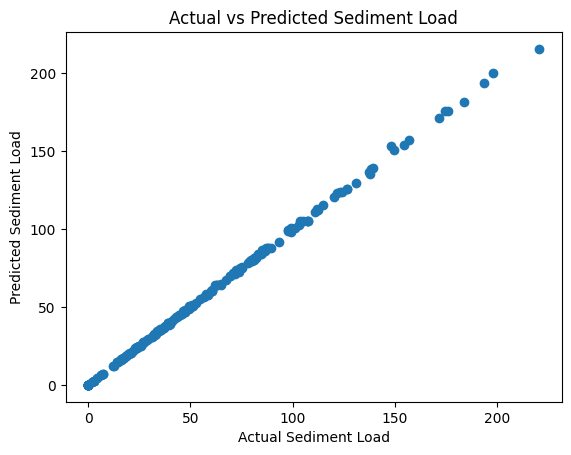

In [25]:
# Scatter Plot (Actual vs Predicted)

plt.scatter(comparison["Actual_Sediment"], comparison["Predicted_Sediment"])
plt.xlabel("Actual Sediment Load")
plt.ylabel("Predicted Sediment Load")
plt.title("Actual vs Predicted Sediment Load")
plt.show()


In [26]:
# Feature Importance

importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
})

importance.sort_values(by="Importance", ascending=False)


,Feature,Importance
2,Slope,0.999490
1,Runoff,0.000248
0,Rainfall,0.000230
3,LULC,0.000033
